In [54]:
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.elementwise import ElementwiseKernel

In [55]:
from scipy.integrate import quad as integrate, trapz 
from scipy import interpolate
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [56]:
lq = 3
Num = 100_000 # количество генерируемых точек
hxi = 0.001*np.pi # шаг генерации
beta = 0.0276 # температурный множитель
l = 2*np.pi # область генерации начального распределения
n = int(l/hxi)
phix = 0 # 

## Блок определения точек начального распределения

# Блок начального распределения состояний (предподготовка)
### вычисляем статсумму. не берем интеграл по бесконечному интервалу, потому что функция слишком быстро стремится к нулю, а встроенные методы пренебрегают пиком в центре интервала
Речь о случае Phix = pi, когда статсумма очень маленькая. Тут используем интегрирование трапециями и оно дает результат, идентичный выводу в Mathematica

In [69]:
LL = 10*np.pi # интервал, на котором производится интегрирование
X = np.linspace(-LL/2, LL/2, 10_000)

def fun(x): # функция распределения
    return np.exp((np.cos(x)-1)/beta)*np.exp(-((x-phix)**2)/(2*lq*beta))
part_func = trapz(fun(X), X)
# print('Статсумма = ', part_func, 'в математике получили 6.39276*10^-20 при phix = Pi')

In [70]:
xi = np.linspace(-np.pi + phix, np.pi + phix, n)
# применяем определение функции распределения
def prob(xx):
    return integrate(lambda phi: coor_destr(phi), -np.pi, xx)[0]

In [71]:
def U(x): 
    return (x-phix)**2/(2*lq) + 1 - np.cos(x)

def coor_destr(x):
    return np.exp(-U(x)/beta)/part_func

xi = np.linspace(-np.pi + phix, np.pi + phix, n)
# применяем определение функции распределения
def prob(xx):
    return integrate(lambda phi: coor_destr(phi), -np.inf, xx)[0]

In [72]:
alpha = []
for xx in xi:
    alpha.append(prob(xx))

inter_func = interpolate.interp1d(alpha, xi) # интерполирующая функция

#plt.plot(alpha, inter_func(alpha))
#plt.title('Обратная функция распределения')
#plt.xlabel('F(x)')
#plt.ylabel('x')
#plt.show()
# Функция распределения - вероятность того, что случайная величина X примет значение, 
# меньшее или равное х, где х — произвольное действительное число

### Господа начальные состония собственной персоной

In [79]:
np.random.seed(1997)
random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
phi_points = inter_func(random_points) # значения phi c требуемым распределением
p_points = np.random.normal(0, np.sqrt(beta), Num)
# применяем свойство независимости распределений
#all_points = np.column_stack((phi_points, p_points))

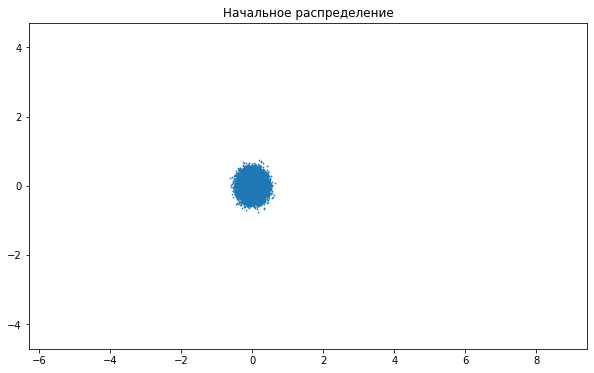

In [80]:
plt.figure(figsize=(10,6))
plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек
plt.xlim(-2*np.pi+phix, 3*np.pi+phix)
plt.ylim(-1.5*np.pi, 1.5*np.pi)
plt.title('Начальное распределение')
plt.show()

Раньше метод Рунге-Кутты выполнялся в векторном виде. Поскольку я только представляю как это сделать в ядре, придется выполнить параллельно два вычисления для разности фаз и импльса. 

$\textbf{y}'= f(x, \textbf{y})$

$k_1 = f(x_n, \textbf{y}_n)$

$k_2 = f(x_n + h/2, \textbf{y}_n + hk_1/2)$

$k_3 = f(x_n + h/2, \textbf{y}_n + hk_2/2)$

$k_4 = f(x_n + h, \textbf{y}_n + hk_3)$

$\textbf{y}_{n+1} = \textbf{y}_{n} + h(k_1+2k_2+2k_3+k_4)/6$.

Раньше $\textbf{y}_{n+1} = (\varphi, p)$, a $f(x, \textbf{y})$ из системы уранений Гамильтониана $ = (p, -\frac{\varphi - \varphi_{ex}(t)}{lq}-\sin \varphi - \gamma p)$, где $\varphi_{ex} = \pi(\tanh(\frac{2\pi t}{tau}-\pi)+1)$.


In [75]:
runge_kutta_ker = ElementwiseKernel(
"float *phi_points, float *p_points, int t_iter, float dt, int tau, int lq, float gamma",
"""
const double PI = 3.141592653589793238463;
int j;
float k1_phi, k2_phi, k3_phi, k4_phi;
float k1_p, k2_p, k3_p, k4_p;
for(j = 0; j < t_iter; j++)
    {
    k1_phi = p_points[i];
    k1_p = -sin(phi_points[i])-(phi_points[i]-PI*(tanh(2*PI*j*dt/tau-PI)+1))/lq - gamma*p_points[i];
    k2_phi = p_points[i] + dt*k1_p/2;
    k2_p = -sin(phi_points[i] + dt*k1_phi/2)-(phi_points[i] + dt*k1_phi/2-PI*(tanh(2*PI*(j*dt+dt/2)/tau-PI)+1))/lq - gamma*(p_points[i] + dt*k1_p/2);
    k3_phi = p_points[i] + dt*k2_p/2;
    k3_p = -sin(phi_points[i] + dt*k2_phi/2)-(phi_points[i] + dt*k2_phi/2-PI*(tanh(2*PI*(j*dt+dt/2)/tau-PI)+1))/lq - gamma*(p_points[i] + dt*k2_p/2);
    k4_phi = p_points[i] + dt*k3_p;
    phi_points[i]  += dt*(k1_phi+2*k2_phi+2*k3_phi+k4_phi)/6;
    k4_p = -sin(phi_points[i] + dt*k3_phi)-(phi_points[i] + dt*k3_phi-PI*(tanh(2*PI*(j*dt+dt)/tau-PI)+1))/lq - gamma*(p_points[i] + dt*k3_p);
    p_points[i] += dt*(k1_p+2*k2_p+2*k3_p+k4_p)/6;
    } 
""",
"runge_kutta_ker")

In [81]:
runge_kutta_ker = ElementwiseKernel(
"float *phi_points, float *p_points, int t_iter, float dt, int tau, int lq, float gamma",
"""
int j;
float k1_phi, k2_phi, k3_phi, k4_phi;
float k1_p, k2_p, k3_p, k4_p;
for(j = 0; j < t_iter; j++)
    {
    k1_phi = p_points[i];
    k1_p = -sin(phi_points[i])-phi_points[i]/lq;
    k2_phi = p_points[i] + dt*k1_p/2;
    k2_p = -sin(phi_points[i] + dt*k1_phi/2)-(phi_points[i] + dt*k1_phi/2)/lq;
    k3_phi = p_points[i] + dt*k2_p/2;
    k3_p = -sin(phi_points[i] + dt*k2_phi/2)-(phi_points[i] + dt*k2_phi/2)/lq;
    k4_phi = p_points[i] + dt*k3_p;
    phi_points[i] =+ dt*(k1_phi+2*k2_phi+2*k3_phi+k4_phi)/6;
    k4_p = -sin(phi_points[i] + dt*k3_phi)-(phi_points[i] + dt*k3_phi)/lq;
    p_points[i] =+ dt*(k1_p+2*k2_p+2*k3_p+k4_p)/6;
    } 
""",
"runge_kutta_ker")

In [82]:
gamma = 0. # коэффициент затухания
tau = 1 # характерное время переключения
T = 1 # полный интервал времени
dt = 0.01 # шаг по времени
t = np.linspace(0,T, int(T/dt))
t_iter = int(T/dt)

In [83]:
# перераспределяем начальные значения 
phi_points_gpu = gpuarray.to_gpu(phi_points)
p_points_gpu = gpuarray.to_gpu(phi_points)
runge_kutta_ker(phi_points_gpu, p_points_gpu, np.int32(t_iter), np.float32(dt), np.int32(tau), np.int32(lq), np.float32(gamma))
phi_points = phi_points_gpu.get()
p_points = p_points_gpu.get()

C:\Users\Gorchavkina\anaconda3\lib\site-packages\pycuda\elementwise.py:75: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  options=options, keep=keep)


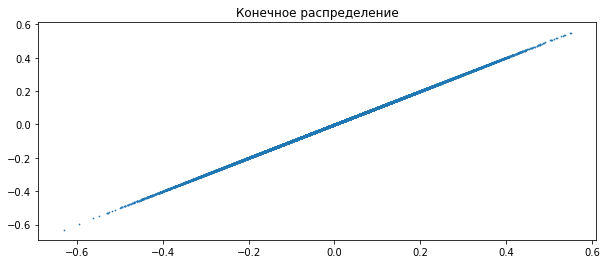

In [84]:
plt.figure(figsize=(10,4))
plt.scatter(phi_points, p_points, s = 0.5) # s - размер точек 
plt.title('Конечное распределение') 
plt.show()